# Enhancing off-disk emission

- https://docs.sunpy.org/en/stable/generated/gallery/computer_vision_techniques/off_limb_enhance.html

How to enhance emission above the limb.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.visualization.mpl_normalize import ImageNormalize

import sunpy.map
from sunpy.data.sample import AIA_171_IMAGE
from sunpy.map.maputils import all_coordinates_from_map

We start with the sample data.

In [ ]:
aia = sunpy.map.Map(AIA_171_IMAGE)

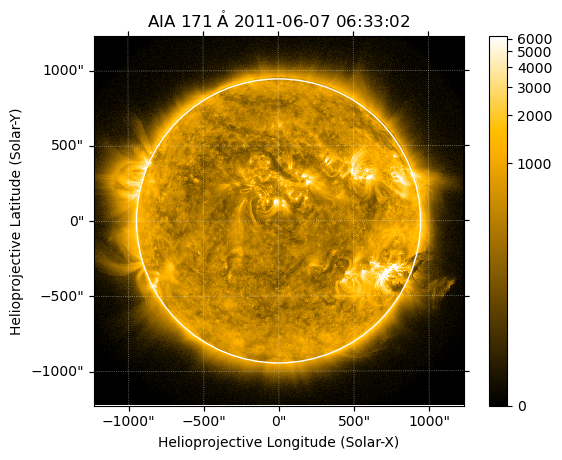

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia)
im = aia.plot(axes=ax, clip_interval=(5, 99.9)*u.percent)
aia.draw_limb(axes=ax)
fig.colorbar(im)
plt.show()

A utility function gives us access to the helioprojective coordinate of each
pixels. We can use that to create a new array which
contains the normalized radial position for each pixel.

In [ ]:
hpc_coords = all_coordinates_from_map(aia)
r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / aia.rsun_obs

Let's check how emission above the limb depends on distance.

In [ ]:
rsun_step_size = 0.01
rsun_array = np.arange(1, r.max(), rsun_step_size)
y = np.array([aia.data[(r > this_r) * (r < this_r + rsun_step_size)].mean()
              for this_r in rsun_array])

Next let's plot it along with a fit to the data. We perform the fit in
linear-log space.

In [ ]:
params = np.polyfit(rsun_array[rsun_array < 1.5],
                    np.log(y[rsun_array < 1.5]), 1)

Let's plot the results using LaTeX for all the text.

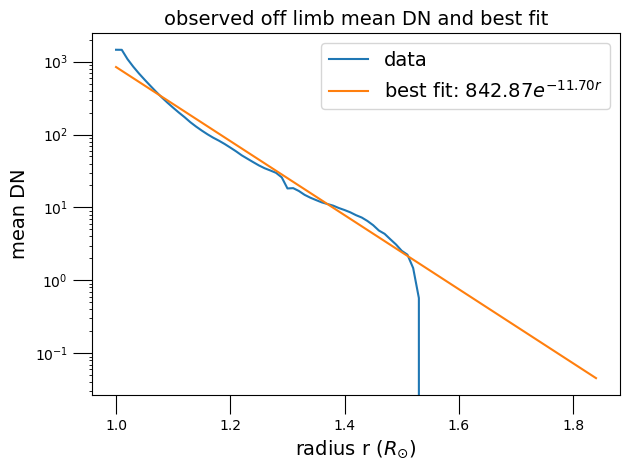

In [ ]:
fontsize = 14
fig, ax = plt.subplots()

ax.plot(rsun_array, y, label='data')
best_fit = np.exp(np.poly1d(params)(rsun_array))
label = fr'best fit: {best_fit[0]:.2f}$e^{{{params[0]:.2f}r}}$'
ax.plot(rsun_array, best_fit, label=label)
ax.set_yscale('log')
ax.set_ylabel(r'mean DN', fontsize=fontsize)
ax.set_xlabel(r'radius r ($R_{\odot}$)', fontsize=fontsize)
ax.tick_params(axis='both', size=fontsize)
ax.set_title(r'observed off limb mean DN and best fit', fontsize=fontsize)
ax.legend(fontsize=fontsize)
fig.tight_layout()

plt.show()

We now create our normalization array. At the solar radius and below, the
normalization is 1, while off-disk the normalization changes according to the
function we fit above.

In [ ]:
scale_factor = np.exp((r-1)*-params[0])
scale_factor[r < 1] = 1

Finally we create a new map with the normalized off-disk emission.
We set the normalization of the new map to be the same as the original map
to compare the two.

In [ ]:
scaled_map = sunpy.map.Map(aia.data * scale_factor, aia.meta)
scaled_map.plot_settings['norm'] = ImageNormalize(stretch=aia.plot_settings['norm'].stretch)

Let's plot the results.

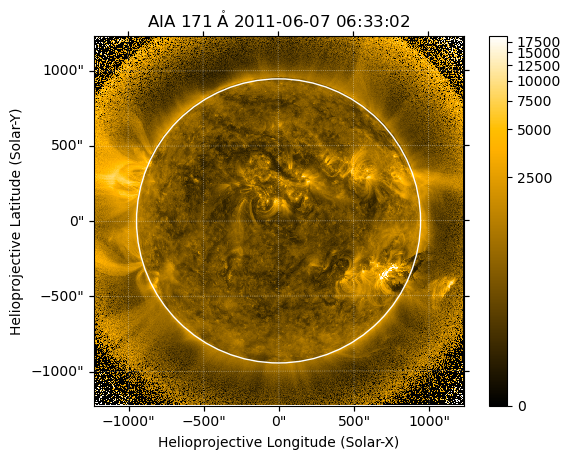

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=scaled_map)
im = scaled_map.plot(axes=ax, clip_interval=(5, 99.9)*u.percent)
scaled_map.draw_limb(axes=ax)
fig.colorbar(im)
plt.show()